# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.382891,True,2.784557
1,0.821793,True,4.136816
2,-0.350774,False,0.071014
3,0.971263,True,6.345343
4,-0.245283,False,0.789573
...,...,...,...
995,1.561229,True,4.816919
996,0.385625,True,4.878601
997,-1.530969,False,-0.507780
998,0.900969,True,4.118908


<AxesSubplot: xlabel='v0'>

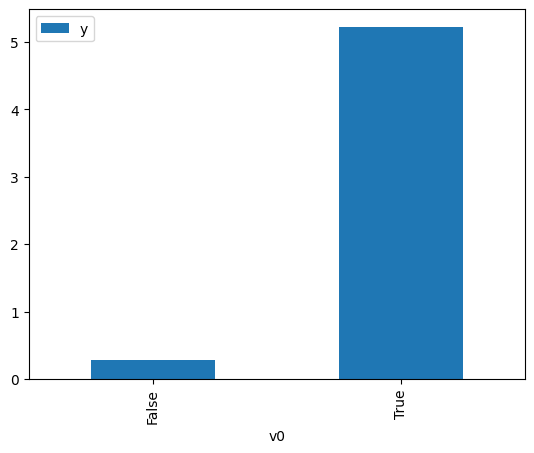

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

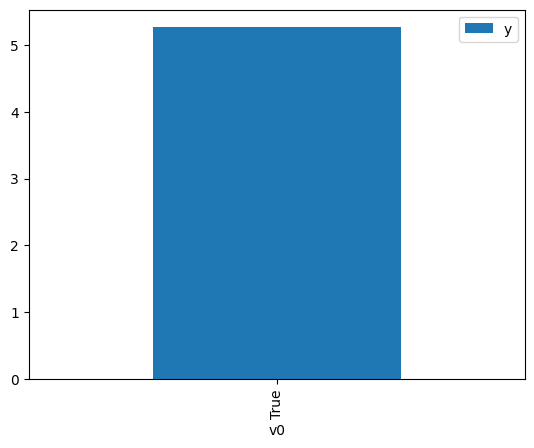

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.590264,False,-0.321082,0.276248,3.619931
1,-1.586264,False,0.855019,0.922038,1.084554
2,0.184716,False,-0.153775,0.419850,2.381802
3,1.203749,False,2.085674,0.126647,7.895947
4,0.098100,False,-1.546204,0.453448,2.205325
...,...,...,...,...,...
995,-1.586264,False,0.855019,0.922038,1.084554
996,2.517395,False,0.333563,0.017929,55.775141
997,1.785942,False,0.318578,0.054715,18.276632
998,0.292756,False,1.313644,0.378993,2.638568


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.852354,True,5.673571,0.798445,1.252435
1,-0.166745,True,4.352468,0.442493,2.259922
2,-0.249010,True,4.651411,0.410760,2.434511
3,1.456863,True,5.839136,0.911350,1.097274
4,-1.238192,True,3.687854,0.127719,7.829689
...,...,...,...,...,...
995,0.549022,True,4.103814,0.710556,1.407348
996,1.536799,True,5.925183,0.921023,1.085749
997,0.730952,True,6.979647,0.765861,1.305720
998,-0.819740,True,5.113712,0.220774,4.529519


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.952
Model:                            OLS   Adj. R-squared (uncentered):              0.952
Method:                 Least Squares   F-statistic:                              9939.
Date:                Thu, 30 Mar 2023   Prob (F-statistic):                        0.00
Time:                        21:55:55   Log-Likelihood:                         -1406.0
No. Observations:                1000   AIC:                                      2816.
Df Residuals:                     998   BIC:                                      2826.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.6091      0.037     16.403      0.000       0.536       0.682
x2             4.9118      0.051     95.538      0.000       4.811       5.013
==============================================================================
Omnibus:                        3.667   Durbin-Watson:                   1.920
Prob(Omnibus):                  0.160   Jarque-Bera (JB):                3.574
Skew:                          -0.145   Prob(JB):                        0.168
Kurtosis:                       3.046   Cond. No.                         2.35
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""